In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
#from ydata_profiling import ProfileReport #incredible library for fast/simple data reporting
# First part will involve explore the data set available to me for the Master Thesis topic:
# Algorithmic Venture insights (exploring ML in VC)
# I acknowledge the limited scope of the application of ML 1) due to limited dataset (outdated)
# 2) scope of the practical application - focused on patterns "features" (i.e. other studies
# tried enriching their dataset with LinkedIN, Twitter and other data; there are classification,
# as well as regression tasks involving startups/VC and Machine learning - more on that in
# the literature review of the thesis)

# Loading data and initial inspection

In [2]:
# Loading the datasets (acquisitions, investments, rounds, companies)
acquisitions = pd.read_csv('/Users/Tom/Library/Mobile Documents/com~apple~CloudDocs/Uni Wien/Thesis/Other/startupsuccess_vc_github/acquisitions.csv')
investments = pd.read_csv('/Users/Tom/Library/Mobile Documents/com~apple~CloudDocs/Uni Wien/Thesis/Other/startupsuccess_vc_github/investments.csv')
rounds = pd.read_csv('/Users/Tom/Library/Mobile Documents/com~apple~CloudDocs/Uni Wien/Thesis/Other/startupsuccess_vc_github/rounds.csv')
companies = pd.read_csv('/Users/Tom/Library/Mobile Documents/com~apple~CloudDocs/Uni Wien/Thesis/Other/startupsuccess_vc_github/companies.csv')

In [3]:
# Understanding each dataset

print("Acquisitions info: ", acquisitions.info())
print("Investments info: ", investments.info())
print("Rounds info: ", rounds.info())
print("Companies info: ", companies.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18968 entries, 0 to 18967
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   company_permalink       18968 non-null  object 
 1   company_name            18968 non-null  object 
 2   company_category_list   13985 non-null  object 
 3   company_country_code    14300 non-null  object 
 4   company_state_code      14020 non-null  object 
 5   company_region          14058 non-null  object 
 6   company_city            14058 non-null  object 
 7   acquirer_permalink      18968 non-null  object 
 8   acquirer_name           18968 non-null  object 
 9   acquirer_category_list  16580 non-null  object 
 10  acquirer_country_code   17798 non-null  object 
 11  acquirer_state_code     17533 non-null  object 
 12  acquirer_region         17609 non-null  object 
 13  acquirer_city           17609 non-null  object 
 14  acquired_at             18956 non-null

In [4]:
companies[companies['name'] == '1mpact Revolution - Powering Helpfreely.org']

,permalink,name,homepage_url,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at
108,/organization/1mpact-revolution-powering-helpf...,1mpact Revolution - Powering Helpfreely.org,http://www.1mpactrevolution.com,Non Profit|Online Shopping|Social Fundraising,761234.47320427,operating,ESP,53,Las Palmas De Gran Canaria,Las Palmas De Gran Canaria,4,2013-09-01,2013-09-10,2015-11-01


In [5]:
# Companies dataset represents the core dataset, which will presumably be enriched by (merged with)
# other datasets to create a clean dataset for the ML part
# Not all columns contain relevant data, but those that do need to be handled for missing data
companies.isnull().sum(axis = 0)

permalink                0
name                     1
homepage_url          5058
category_list         3148
funding_total_usd        0
status                   0
country_code          6958
state_code            8547
region                8030
city                  8028
funding_rounds           0
founded_at           15221
first_funding_at        24
last_funding_at          0
dtype: int64

In [6]:
# funding_total, status, first_funding_at (perhaps also founded_at), funding_rounds, last_funding_at
# are neccessary for the feature engineering part of this project --> NaN dropped
companies = companies.dropna(subset=['first_funding_at'])
companies.isnull().sum(axis = 0) #check

permalink                0
name                     1
homepage_url          5058
category_list         3147
funding_total_usd        0
status                   0
country_code          6956
state_code            8545
region                8028
city                  8026
funding_rounds           0
founded_at           15218
first_funding_at         0
last_funding_at          0
dtype: int64

In [7]:
#['homepage_url'] does not give us a lot, though if we were working with current data about
#companies, the column would be
#more valuable as we could use 'requests' | urllib and check if the company has an active page and 
#potentially scrape additional data from that page
# import requests
# from requests.exceptions import RequestException

# def is_url_active(url):
#     try:
#         response = requests.head(url, allow_redirects=True, timeout=5)
#         return response.status_code in range(200, 299)
#     except RequestException:
#         return False

#df['url_active'] = df['urls'].apply(is_url_active)

companies = companies.drop('homepage_url', axis =1)
companies.columns

Index(['permalink', 'name', 'category_list', 'funding_total_usd', 'status',
       'country_code', 'state_code', 'region', 'city', 'funding_rounds',
       'founded_at', 'first_funding_at', 'last_funding_at'],
      dtype='object')

In [8]:
companies[companies['name'].isnull()] #no need to drop, since it can be merged on 'permalink'

,permalink,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at
56916,/organization/tell-it-in,NaN,Startups,25000,closed,USA,OR,"Portland, Oregon",Portland,1,2011-10-01,2012-03-01,2012-03-01


In [9]:
rounds['company_country_code'].value_counts()

company_country_code
USA    72308
GBR     5966
CAN     3115
CHN     2693
IND     2233
       ...  
KNA        1
BRN        1
DZA        1
TGO        1
GGY        1
Name: count, Length: 137, dtype: int64

In [10]:
# As we have data for Acquisitions and not for IPO, do we suppose that 
# the 'last_funding_at' is IPO date? Meaning, how long did it take the 
# company to go public.
companies[companies['status'] == 'ipo']

,permalink,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at
139,/organization/21vianet,21viaNet,Software|Web Hosting,396000000,ipo,CHN,22,Beijing,Beijing,5,2009-10-16,2008-02-13,2014-12-04
140,/organization/22nd-century-group,22nd Century Group,Biotechnology,15034750,ipo,USA,NY,NY - Other,Clarence,6,1998-01-01,2010-12-28,2014-09-18
201,/organization/2u,2U Inc.,EdTech|Education|Software,95875000,ipo,USA,MD,MD - Other,Hyattsville,6,2008-01-01,2009-03-25,2013-10-21
270,/organization/3d-systems,3D Systems,Software,169500000,ipo,USA,SC,SC - Other,Rock Hill,3,1986-01-01,2014-01-15,2014-10-13
436,/organization/58-com,58.com,Curated Web|Internet|Software,876780000,ipo,CHN,19,CHN - Other,Chaoyang,6,2005-01-01,2006-02-01,2014-06-27
...,...,...,...,...,...,...,...,...,...,...,...,...,...
66215,/organization/zoopla,Zoopla,Property Management|Real Estate,13387373.8236279,ipo,GBR,H9,London,London,3,2007-06-01,2007-01-01,2010-12-23
66216,/organization/zooplus,Zooplus,Pets|Trading,-,ipo,DEU,2,Muenchen,Muenchen,1,1999-01-01,2000-01-01,2000-01-01
66235,/organization/zosano-pharma,Zosano Pharma,Biotechnology,158688887,ipo,USA,CA,SF Bay Area,Fremont,9,2006-10-01,2007-11-15,2015-02-03
66350,/organization/zynerba-pharmaceuticals,Zynerba Pharmaceuticals,Pharmaceuticals,13000000,ipo,USA,PA,Philadelphia,Radnor,1,2014-01-01,2014-10-14,2014-10-14


In [11]:
# inspecting the 'first_funding_at', first trial showed some dates that
# fall out of bounds for pd.to_datetime
# errors = 'coerce' renders invalid dates to NaT
# Doing the same for last_funding_at as both columns will be used for a
# feature ['time_since_funding']
companies['first_funding_at'] = pd.to_datetime(companies['first_funding_at'], errors='coerce')
companies['first_funding_at'].isna().sum()

3

In [12]:
companies['last_funding_at'] = pd.to_datetime(companies['last_funding_at'], errors='coerce')
companies['last_funding_at'].isna().sum()

0

In [13]:
companies['founded_at'] = pd.to_datetime(companies['founded_at'], errors='coerce')
companies['founded_at'].isna().sum()

15222

### Dummy Variable for handling missing data (founded_at)

In [14]:
# Creating a new column 'founded_at_missing' to indicate missing values in 'founded_at'
companies['founded_at_missing'] = companies['founded_at'].isna().astype(int)

In [15]:
companies[['founded_at', 'founded_at_missing']].head(10)

,founded_at,founded_at_missing
0,NaT,1
1,2014-09-04,0
2,NaT,1
3,2007-01-01,0
4,2010-01-01,0
5,NaT,1
6,1997-01-01,0
7,2011-01-01,0
8,2011-08-01,0
9,2012-01-01,0


In [16]:
# Count the number of companies founded in each year
year_counts = companies['founded_at'].dt.year.value_counts().sort_index()
year_counts


founded_at
1749.0       1
1766.0       1
1785.0       1
1787.0       1
1789.0       1
          ... 
2015.0    1575
2016.0       2
2041.0       1
2104.0       1
2105.0       1
Name: count, Length: 176, dtype: int64

In [17]:
print(companies['founded_at'].min())
print(companies['founded_at'].max())

1749-01-01 00:00:00
2105-02-17 00:00:00


In [18]:
# Since some of the founding dates make no sense, I decided to reduce
# the time window into years 1998-2015 (included)
# BUT CAREFUL NOT TO DROP DUMMY VARIABLES 0, WHILE CONDITION NEEDED

# Filter companies with a known 'founded_at' date between 1998 and 2015, or with 'founded_at' missing
companies = companies[((companies['founded_at'].dt.year >= 1998) & (companies['founded_at'].dt.year <= 2015)) | (companies['founded_at_missing'] == 1)]

print(companies['founded_at'].min())
print(companies['founded_at'].max())

1998-01-01 00:00:00
2015-12-23 00:00:00


In [19]:
# Additional dropping needs to take place for 'operating' companies
# for company['status'] == operating, the cutoff founded_at date will be
# 2013 (included) - the startup has 2 years to show signs of success.

In [20]:
# Exclude 'operating' companies founded after 2013
companies = companies[~((companies['status'] == 'operating') & (companies['founded_at'].dt.year > 2013))  | (companies['founded_at_missing'] == 1)]

### Operating time for active companies

In [21]:
# Filter the DataFrame
operating_companies = companies[(companies['status'] == 'operating') & (companies['founded_at_missing'] == 0)]
operating_companies.head(5)

,permalink,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,founded_at_missing
3,/organization/0-6-com,0-6.com,Curated Web,2000000,operating,CHN,22,Beijing,Beijing,1,2007-01-01,2008-03-19,2008-03-19,0
4,/organization/004-technologies,004 Technologies,Software,-,operating,USA,IL,"Springfield, Illinois",Champaign,1,2010-01-01,2014-07-24,2014-07-24,0
7,/organization/0xdata,H2O.ai,Analytics,33600000,operating,USA,CA,SF Bay Area,Mountain View,4,2011-01-01,2013-01-03,2015-11-09,0
8,/organization/1,One Inc.,Mobile,1150050,operating,USA,CA,SF Bay Area,San Francisco,3,2011-08-01,2011-07-20,2014-02-05,0
9,/organization/1-2-3-listo,"1,2,3 Listo",E-Commerce,40000,operating,CHL,12,Santiago,Las Condes,1,2012-01-01,2013-02-18,2013-02-18,0


In [22]:
# Define the end date
end_date = pd.to_datetime('2015-12-31')

# Function to calculate operating time
def calculate_operating_time(row):
    if row['status'] == 'operating' and row['founded_at_missing'] == 0:
        return (end_date - row['founded_at']).days / 365
    else:
        return 'not available'

# Apply the function to create the 'operating_time' column
companies['operating_time'] = companies.apply(calculate_operating_time, axis=1)

In [23]:
companies[companies['operating_time'] != 'not available']

,permalink,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,founded_at_missing,operating_time
3,/organization/0-6-com,0-6.com,Curated Web,2000000,operating,CHN,22,Beijing,Beijing,1,2007-01-01,2008-03-19,2008-03-19,0,9.00274
4,/organization/004-technologies,004 Technologies,Software,-,operating,USA,IL,"Springfield, Illinois",Champaign,1,2010-01-01,2014-07-24,2014-07-24,0,6.0
7,/organization/0xdata,H2O.ai,Analytics,33600000,operating,USA,CA,SF Bay Area,Mountain View,4,2011-01-01,2013-01-03,2015-11-09,0,5.0
8,/organization/1,One Inc.,Mobile,1150050,operating,USA,CA,SF Bay Area,San Francisco,3,2011-08-01,2011-07-20,2014-02-05,0,4.419178
9,/organization/1-2-3-listo,"1,2,3 Listo",E-Commerce,40000,operating,CHL,12,Santiago,Las Condes,1,2012-01-01,2013-02-18,2013-02-18,0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66356,/organization/zype,Zype,Cloud Computing|Mobile Advertising|Video|Video...,3300000,operating,USA,NY,New York City,New York,2,2013-01-01,2015-04-01,2015-10-27,0,2.99726
66357,/organization/zypsee,Whisk (formerly Zypsee),Public Transportation,2150000,operating,USA,NY,New York City,New York,2,2011-01-01,2013-07-26,2013-09-25,0,5.0
66361,/organization/zytoprotec,Zytoprotec,Biotechnology,2686600,operating,AUT,3,Vienna,Gerasdorf Bei Wien,1,2007-01-01,2013-01-29,2013-01-29,0,9.00274
66364,/organization/zzzzapp-com,Zzzzapp Wireless ltd.,Advertising|Mobile|Web Development|Wireless,114304,operating,HRV,15,Split,Split,4,2012-05-13,2011-11-01,2014-03-01,0,3.635616


In [24]:
companies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 57202 entries, 0 to 66367
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   permalink           57202 non-null  object        
 1   name                57201 non-null  object        
 2   category_list       54554 non-null  object        
 3   funding_total_usd   57202 non-null  object        
 4   status              57202 non-null  object        
 5   country_code        51146 non-null  object        
 6   state_code          49779 non-null  object        
 7   region              50216 non-null  object        
 8   city                50218 non-null  object        
 9   funding_rounds      57202 non-null  int64         
 10  founded_at          41980 non-null  datetime64[ns]
 11  first_funding_at    57199 non-null  datetime64[ns]
 12  last_funding_at     57202 non-null  datetime64[ns]
 13  founded_at_missing  57202 non-null  int64         


In [25]:
companies['funding_total_usd'] = pd.to_numeric(companies['funding_total_usd'], errors='coerce')
companies['funding_total_usd'].isna().sum()

10572

### Dummy Variable for handling missing data (funding_total_usd)

In [26]:
# Creating a new column 'funding_total_usd_missing' to indicate missing values
companies['funding_total_usd_missing'] = companies['funding_total_usd'].isna().astype(int)

In [27]:
# Replacing missing values in 'funding_total_usd' with 0
companies['funding_total_usd'].fillna(0, inplace=True)

In [28]:
# Checking the first few rows of the DataFrame to verify the changes
companies[['funding_total_usd', 'funding_total_usd_missing']].head()


,funding_total_usd,funding_total_usd_missing
0,10000000.0,0
2,3406878.0,0
3,2000000.0,0
4,0.0,1
5,41250.0,0


In [29]:
#comp_report = ProfileReport(companies, title="Companies Report")
#comp_report

### (above section) This should conlude the basic EDA and preprocessing of companies data

# Geography-based dataset (# not needed now)

In [30]:
# GEOGRAPHY - hypothesis: US startup companies may prevail with number of IPOs compared to 
# rest of the world, since the US market has a stronger IPO market --> therefore separating the
# dataset into US and ROW may be useful for further inspection
# Furthermore, US companies are oversampled in the total dataset of companies

#pd.set_option('display.max_rows', None)

#print(companies['country_code'].value_counts())


In [31]:
# = companies[companies['country_code'] == 'USA']
#us_comp.head()

In [32]:
#us_comp['country_code'].value_counts()

In [33]:
#ChatGPT generated list of EU states
#eu_country_codes = ['AUT', 'BEL', 'BGR', 'HRV', 'CYP', 'CZE', 'DNK', 'EST', 'FIN', 'FRA', 
#                   'DEU', 'GRC', 'HUN', 'IRL', 'ITA', 'LVA', 'LTU', 'LUX', 'MLT', 'NLD', 
#                  'POL', 'PRT', 'ROU', 'SVK', 'SVN', 'ESP', 'SWE']
#eu_comp = companies[companies['country_code'].isin(eu_country_codes)]
#eu_comp['country_code'].value_counts()

In [34]:
#row_comp = rest_of_world_companies = companies[~companies['country_code'].isin(eu_country_codes + ['USA'])]
#row_comp['country_code'].value_counts()

In [35]:
# print(f"US companies shape: {us_comp.shape}")
# print(f"EU companies shape: {eu_comp.shape}")
# print(f"ROW companies shape: {row_comp.shape}")

### What does a Profile Report say about each geographical dataset

In [36]:
# from ydata_profiling import ProfileReport, compare
# # This library enables me to generate professional reports out of dataframes, the form seems
# # suitable for inclusion in the practical part of the thesis

In [37]:
# # us_profile = ProfileReport(us_comp, title="American Report")
# eu_profile = ProfileReport(eu_comp, title="EU Report")
# row_profile = ProfileReport(row_comp, title="Rest of the world Report")

In [38]:
#us_profile

In [39]:
#eu_profile

In [40]:
#row_profile

In [41]:
# comparison_report = compare([us_profile, eu_profile, row_profile])
# comparison_report

# Categories

In [42]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /Users/Tom/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/Tom/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/Tom/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [43]:
# # I want to have a group of 20 unique industries that encompass all value names of the category list
# column of each dataset to. I will aim to create a new column 'Industry' that clusters the values
# of the 'category_list' and serves as a feature in the later stage of this project. For the feature
# engineering part, I will use the default column 'category_list' as subcategory.

In [44]:
# Is this step fine or should we code a dummy variable for missing category
companies['category_list'].fillna('Unknown', inplace=True)

### Tokenization

In [45]:
def process_text(text):
    # Tokenization
    tokens = word_tokenize(text)
    # 
    tokens = [token.lower() for token in tokens]
    # Keeping tokens with hyphens or alphanumeric characters, and removing stopwords except 'other'
    tokens = [token for token in tokens if '-' in token or token.isalpha()]
    tokens = [token for token in tokens if token not in stopwords.words('english') or token == 'unknown']
    return tokens

# Apply text processing to the 'category_list' column
companies['clean_category'] = companies['category_list'].apply(lambda x: process_text(x.replace('|', ' ')))


In [46]:
from collections import Counter

# Flatten the list of lists in 'tokens' column and count occurrences
all_tokens = [token for sublist in companies['clean_category'] for token in sublist]
token_counts = Counter(all_tokens)

# Convert to DataFrame for easy handling
token_counts_df = pd.DataFrame(token_counts.items(), columns=['clean_category', 'Count']).sort_values(by='Count', ascending=False)
print(token_counts_df.head(26))  # Display top 25 tokens ('Unknown will be removed')


    clean_category  Count
6         software  11898
3           mobile   6563
0            media   5090
34          social   5008
46          health   4765
5              web   4622
44      technology   4368
43   biotechnology   4127
8       e-commerce   3799
59        services   3496
4          curated   2907
30     advertising   2797
2            games   2704
85         unknown   2648
14        internet   2633
36      enterprise   2608
114           care   2414
7        analytics   2353
15       marketing   2289
82         finance   1926
77            data   1903
20       education   1843
62            saas   1712
186     management   1709
47        wellness   1704
151       hardware   1673


In [47]:
top_industry = token_counts_df['clean_category'].head(26).tolist()

# unknown will be removed from the list --> it will be later assigned a
# value 'other' 
top_industry.remove('unknown')
# List of additional categories to append
additional_categories = ['manufacturing', 'security', 'travel', 'semiconductors', 'real', 'estate']

# Append additional categories to top_industry list
top_industry.extend(additional_categories)
top_industry

['software',
 'mobile',
 'media',
 'social',
 'health',
 'web',
 'technology',
 'biotechnology',
 'e-commerce',
 'services',
 'curated',
 'advertising',
 'games',
 'internet',
 'enterprise',
 'care',
 'analytics',
 'marketing',
 'finance',
 'data',
 'education',
 'saas',
 'management',
 'wellness',
 'hardware',
 'manufacturing',
 'security',
 'travel',
 'semiconductors',
 'real',
 'estate']

In [48]:
def category_filter(categories_list):
    if 'unknown' in categories_list:
        return 0
    for industry in top_industry:
        if industry in categories_list:
            return industry
    return 'other'

# Apply the function to the DataFrame
companies['single_category'] = companies['clean_category'].apply(category_filter)
companies[['category_list', 'clean_category', 'single_category']]

,category_list,clean_category,single_category
0,Media,[media],media
2,Apps|Games|Mobile,"[apps, games, mobile]",mobile
3,Curated Web,"[curated, web]",web
4,Software,[software],software
5,Games,[games],games
...,...,...,...
66361,Biotechnology,[biotechnology],biotechnology
66363,Enterprise Software,"[enterprise, software]",software
66364,Advertising|Mobile|Web Development|Wireless,"[advertising, mobile, web, development, wireless]",mobile
66365,Unknown,[unknown],0


In [49]:
companies[companies['status'] == 'ipo'].head(10)

,permalink,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,founded_at_missing,operating_time,funding_total_usd_missing,clean_category,single_category
139,/organization/21vianet,21viaNet,Software|Web Hosting,396000000.0,ipo,CHN,22,Beijing,Beijing,5,2009-10-16,2008-02-13,2014-12-04,0,not available,0,"[software, web, hosting]",software
140,/organization/22nd-century-group,22nd Century Group,Biotechnology,15034750.0,ipo,USA,NY,NY - Other,Clarence,6,1998-01-01,2010-12-28,2014-09-18,0,not available,0,[biotechnology],biotechnology
201,/organization/2u,2U Inc.,EdTech|Education|Software,95875000.0,ipo,USA,MD,MD - Other,Hyattsville,6,2008-01-01,2009-03-25,2013-10-21,0,not available,0,"[edtech, education, software]",software
436,/organization/58-com,58.com,Curated Web|Internet|Software,876780000.0,ipo,CHN,19,CHN - Other,Chaoyang,6,2005-01-01,2006-02-01,2014-06-27,0,not available,0,"[curated, web, internet, software]",software
442,/organization/5barz-international,5BARz International,Mobile|Technology|Wireless,6100000.0,ipo,USA,WA,Seattle,Seattle,2,2008-01-01,2013-11-12,2014-11-17,0,not available,0,"[mobile, technology, wireless]",mobile
468,/organization/6d-global-technologies,6D Global Technologies,Services,11052498.0,ipo,USA,NY,New York City,New York,2,NaT,2014-12-02,2015-08-20,1,not available,0,[services],services
639,/organization/a10-networks,A10 Networks,Cloud Computing|Communications Hardware|Hardwa...,118000000.0,ipo,USA,CA,SF Bay Area,San Jose,4,2004-10-01,2005-01-01,2013-10-03,0,not available,0,"[cloud, computing, communications, hardware, h...",web
640,/organization/a123systems,A123 Systems,Batteries|Clean Technology|Energy Storage|Mobile,502860000.0,ipo,USA,MA,Worcester,Westborough,8,2001-01-01,2005-11-01,2012-06-07,0,not available,0,"[batteries, clean, technology, energy, storage...",mobile
647,/organization/a8-digital-music,A8 Digital Music,Music,50000000.0,ipo,CHN,30,Shenzhen,Shenzhen,2,2000-01-01,2004-10-01,2005-12-08,0,not available,0,[music],other
743,/organization/ablynx,Ablynx,Biotechnology,186036236.0,ipo,BEL,8,BEL - Other,Zwijnaarde,6,2001-01-01,2002-09-25,2014-08-13,0,not available,0,[biotechnology],biotechnology


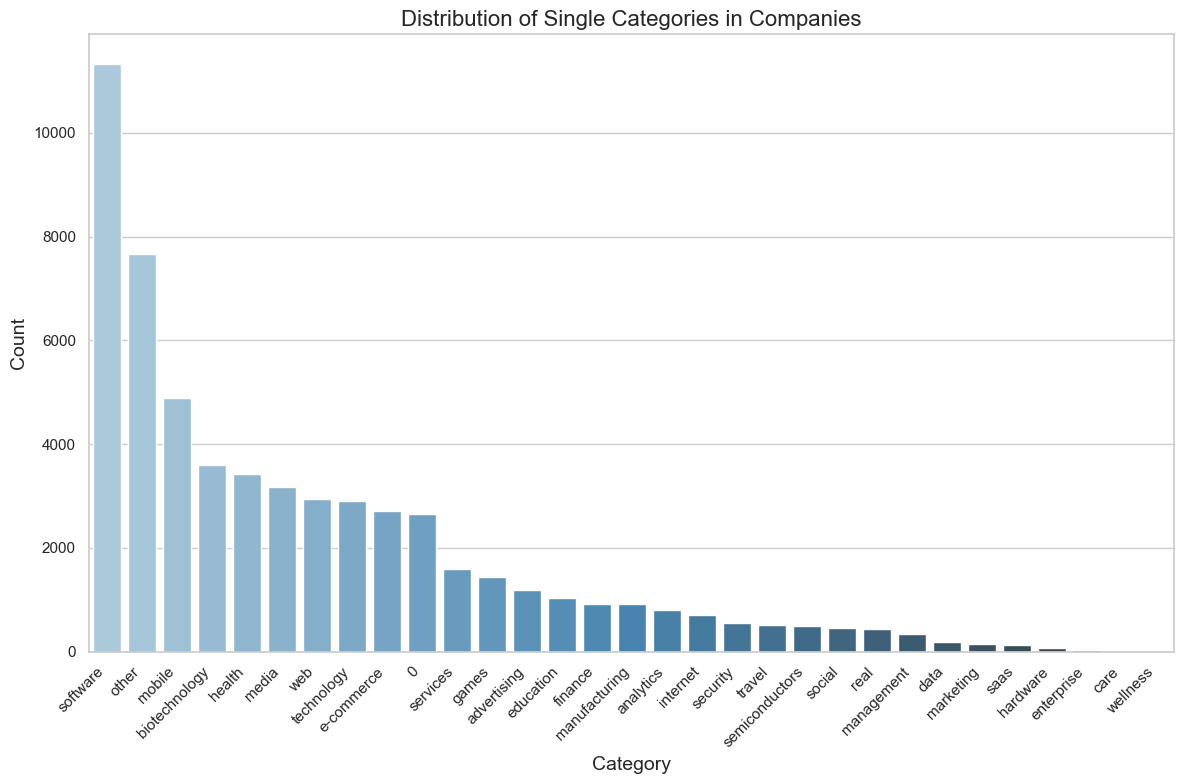

In [50]:
# Count the occurrences of each category
category_counts = companies['single_category'].value_counts()

# Setting the plot style
sns.set(style="whitegrid")

# Create a bar plot
plt.figure(figsize=(12, 8))
barplot = sns.barplot(x=category_counts.index, y=category_counts.values, palette="Blues_d")

# Rotate x labels for better readability
plt.xticks(rotation=45, ha='right')

# Setting title and labels
plt.title('Distribution of Single Categories in Companies', fontsize=16)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()

In [51]:
companies.to_csv('clean_companies2.csv', index = False)

In [52]:
df = pd.read_csv('clean_companies2.csv')
df

,permalink,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,founded_at_missing,operating_time,funding_total_usd_missing,clean_category,single_category
0,/organization/-fame,#fame,Media,10000000.0,operating,IND,16,Mumbai,Mumbai,1,NaN,2015-01-05,2015-01-05,1,not available,0,['media'],media
1,/organization/-the-one-of-them-inc-,"(THE) ONE of THEM,Inc.",Apps|Games|Mobile,3406878.0,operating,NaN,NaN,NaN,NaN,1,NaN,2014-01-30,2014-01-30,1,not available,0,"['apps', 'games', 'mobile']",mobile
2,/organization/0-6-com,0-6.com,Curated Web,2000000.0,operating,CHN,22,Beijing,Beijing,1,2007-01-01,2008-03-19,2008-03-19,0,9.002739726027396,0,"['curated', 'web']",web
3,/organization/004-technologies,004 Technologies,Software,0.0,operating,USA,IL,"Springfield, Illinois",Champaign,1,2010-01-01,2014-07-24,2014-07-24,0,6.0,1,['software'],software
4,/organization/01games-technology,01Games Technology,Games,41250.0,operating,HKG,NaN,Hong Kong,Hong Kong,1,NaN,2014-07-01,2014-07-01,1,not available,0,['games'],games
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57197,/organization/zytoprotec,Zytoprotec,Biotechnology,2686600.0,operating,AUT,3,Vienna,Gerasdorf Bei Wien,1,2007-01-01,2013-01-29,2013-01-29,0,9.002739726027396,0,['biotechnology'],biotechnology
57198,/organization/zznode-science-and-technology-co...,ZZNode Science and Technology,Enterprise Software,1587301.0,operating,CHN,22,Beijing,Beijing,1,NaN,2012-04-01,2012-04-01,1,not available,0,"['enterprise', 'software']",software
57199,/organization/zzzzapp-com,Zzzzapp Wireless ltd.,Advertising|Mobile|Web Development|Wireless,114304.0,operating,HRV,15,Split,Split,4,2012-05-13,2011-11-01,2014-03-01,0,3.6356164383561644,0,"['advertising', 'mobile', 'web', 'development'...",mobile
57200,/organization/Áeron,ÁERON,Unknown,0.0,operating,NaN,NaN,NaN,NaN,1,2011-01-01,2014-08-01,2014-08-01,0,5.0,1,['unknown'],0
